# Oct 30, 2023: ROI time series extraction and back-projection

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse

# nii imaging
from allensdk.core.mouse_connectivity_cache import (
    MouseConnectivityCache,
    MouseConnectivityApi
)
import nrrd
import ants

# networkx
import networkx as nx 

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.out_path = (
    f'/home/govindas/mouse_dataset/allen_atlas_ccfv3' 
    f'/hadi/parcellation'
)

In [3]:
regions_df = pd.read_pickle(f'{args.out_path}/regions.df')
layers02 = regions_df[regions_df.acro == 'Isocortex'][regions_df.layer.isin([0, 2])]

In [4]:
regions_modified_df = regions_df.drop(layers02.index)
regions_modified_df = regions_modified_df.reset_index(drop=True)
regions_modified_df

,id,acro,hemis,region,layer
0,193,Isocortex,1,1,1
1,194,Isocortex,1,2,1
2,195,Isocortex,1,3,1
3,196,Isocortex,1,4,1
4,197,Isocortex,1,5,1
...,...,...,...,...,...
681,1450,CB,2,1425,-1
682,1451,CB,2,1426,-1
683,1452,CB,2,1427,-1
684,1453,CB,2,1428,-1


In [5]:
parcels_img = ants.image_read(
    f'{args.out_path}/warped_on_n162/parcels_warped_cm.nii.gz'
)
parcels = parcels_img.numpy()
len(np.unique(parcels))

687

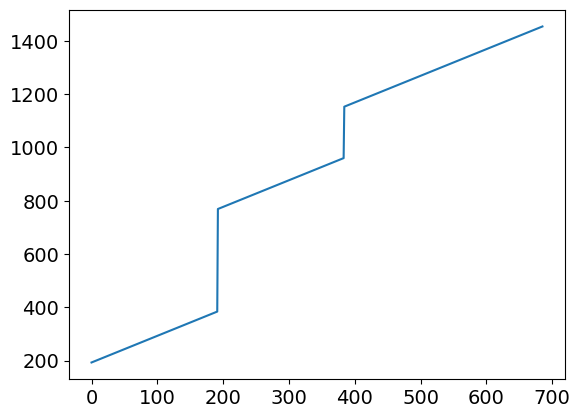

In [6]:
rois = regions_modified_df.id.values
parcels_test = np.zeros_like(parcels)
for roi in rois:
    parcels_test += (parcels == roi) * roi 

parcels_img.new_image_like(
    data=parcels_test
).to_filename(
    f'/home/govindas/mouse_dataset/roi/tmp/parcels_test.nii.gz'
)
plt.plot(range(len(rois)), rois)

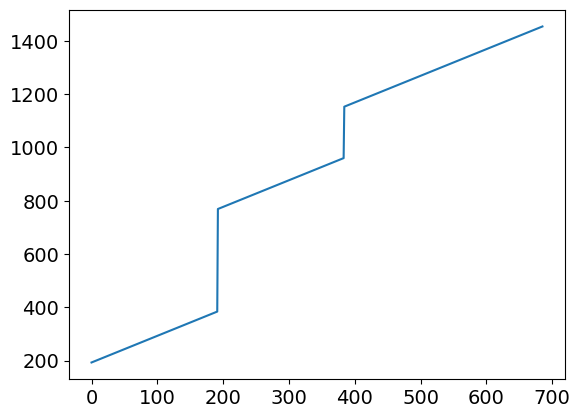

In [7]:
roi_labels = np.loadtxt(
    f'/home/govindas/mouse_dataset/roi/tmp/atlas_ts.txt'
)
plt.plot(range(len(roi_labels)), roi_labels)

In [8]:
ts = np.loadtxt(
    f'/home/govindas/mouse_dataset/roi/tmp/ts.txt'
)
print(ts.shape)
vs = np.zeros(ts.shape[1])
vs[[0, 34, 67]] = np.std(ts, axis=0)[[0, 34, 67]]
print(vs.shape)

vs[[0, 34, 67]]

(522, 686)
(686,)


array([0.48990664, 0.52849162, 0.51280994])

In [9]:
roi_labels[[0, 34, 67]]

array([193., 227., 260.])

In [10]:
groups = np.zeros_like(parcels)
for idx, roi in enumerate(roi_labels):
    groups += (parcels_test == roi) * vs[idx]
parcels_img.new_image_like(
    groups
).to_filename(
    f'/home/govindas/mouse_dataset/roi/tmp/groups.nii.gz'
)

In [12]:
regions_df.to_csv(
    f'/home/govindas/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation/regions.csv'
)